In [4]:
library('hdp')
library('clusterCrit')
library('grid')
library('gridExtra')
library('ggplot2')
library('ggrepel')
library('RColorBrewer')
library('dplyr')
library('reshape2')
library('IRdisplay')
source('../../../src/tools.R')     # custom tools function
#source('../../../src/hdp_tools.R') # hdp related functions
source('../../../src/hdp_tools_yanis.R')
library(scales)
theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [5]:
df_final <- read.table("../../../data/updated_dataset/modif_final.csv",sep = ',' , header = T)
rownames(df_final)<- df_final$data_pd
df_final <- df_final[,-1:-3]
dd_predicted_10_components <- read.table("dd_predicted_10_components.tsv",sep = '\t' , header = T)

In [6]:
launch <- function(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab){
    number_of_chains <- chains
    chain_list <- vector('list', number_of_chains)
    hdp <- initialise_hdp_yanis(data = data,hh=base_dist,alphaa = aa,alphab= ab)


    for (i in 1:number_of_chains) {
        seed <- i * 100
        print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))

        # run single hdp chain
        chain_list[[i]] <- activate_and_run_hdp(hdp,
                                                initcc = initial_clusters,
                                                burnin = burn,
                                                n      = posterior_samples,
                                                space  = 20,
                                                seed   = seed)
        print_and_flush('\n')
    }

    multi_output <- hdp_multi_chain(chain_list)
    print(multi_output)
}

In [7]:

num_cols = ncol(df_final)
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1))/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_final,bin))
gaussian <- unlist(sapply(df_final,normal))
pois <- as.numeric(unlist(sapply(df_final,poisson)))
unif <- unlist(sapply(df_final,equally))
repetition <- unlist(sapply(df_final,repet))
lists<- list(binomial,gaussian,unif,repetition)


In [8]:
data <- df_final
posterior_samples <- 250
initial_clusters <- 17
burn <- 7000
chains <- 3
base_dist <- gaussian
aa <- 2
ab <-0.5

# I) Initial Component : Component 0 to 10

In [ ]:
multi_output <- launch(data,base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_cluster_10 <- extract_components(multi_output)

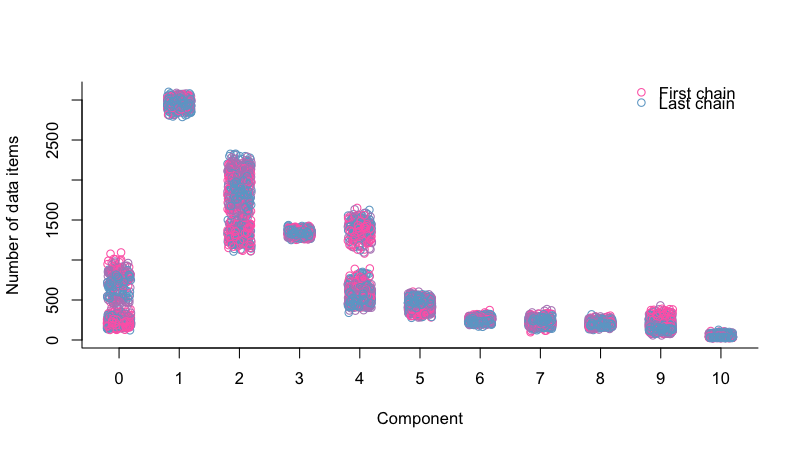

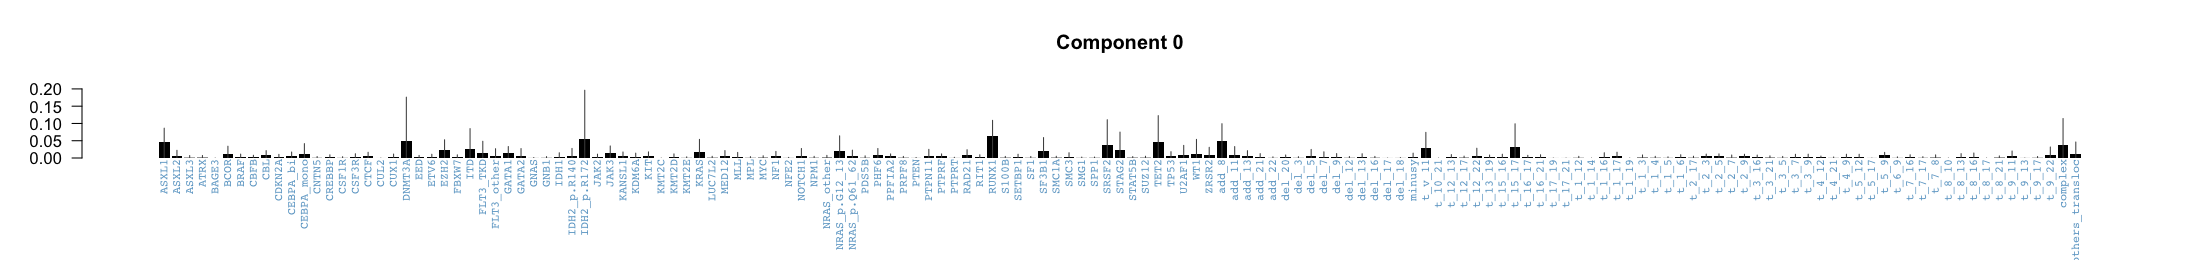

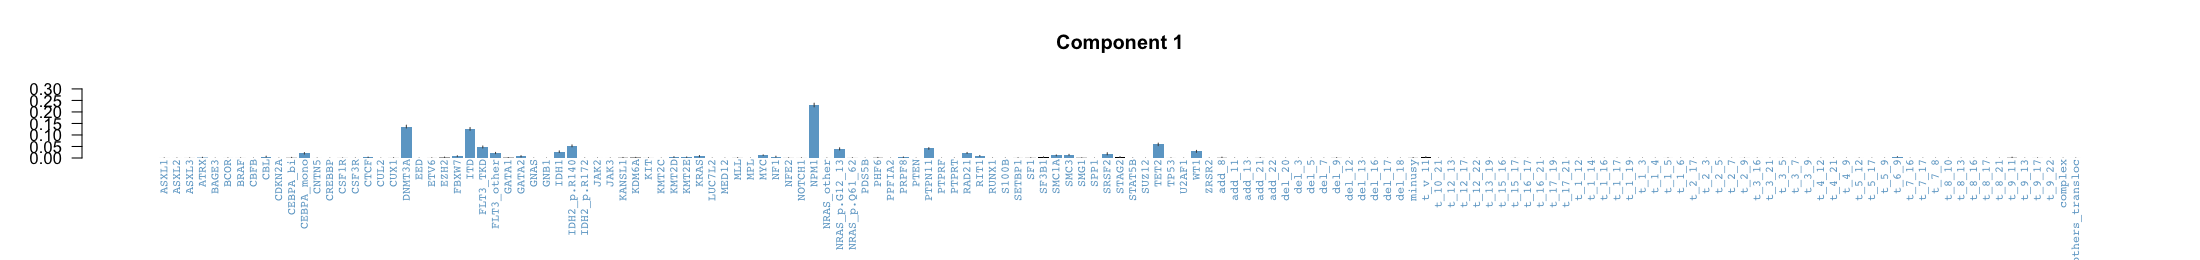

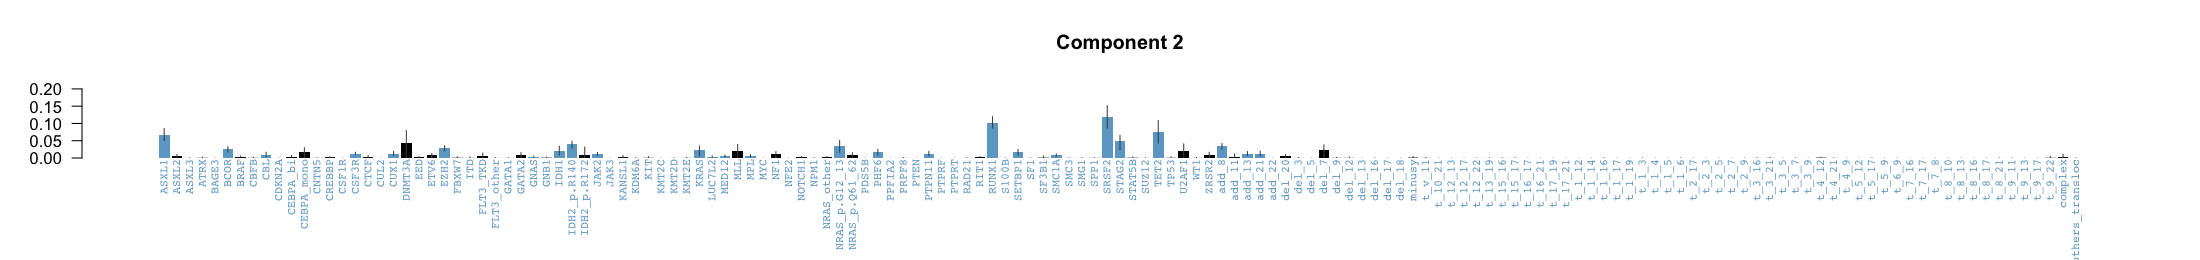

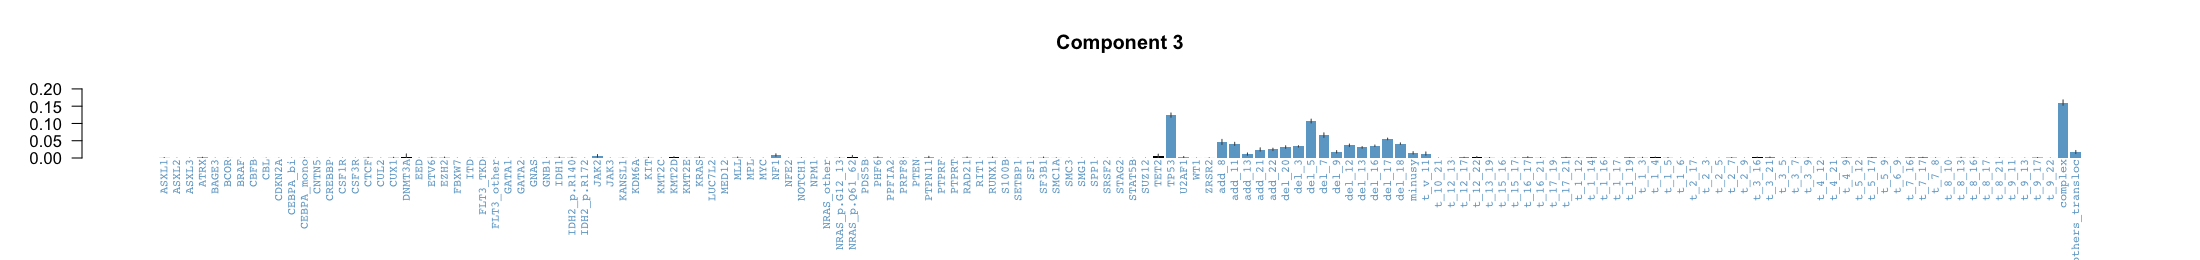

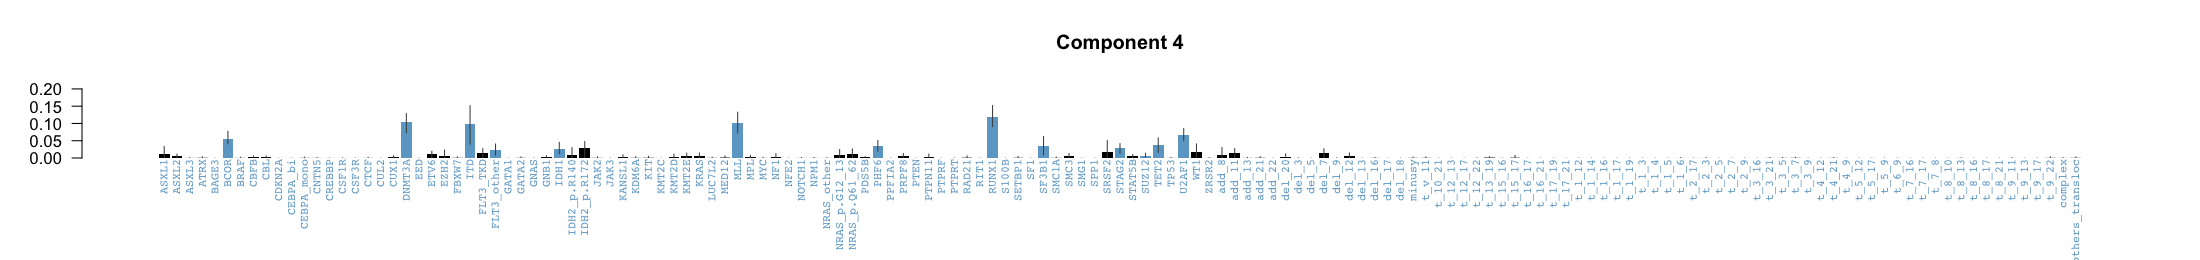

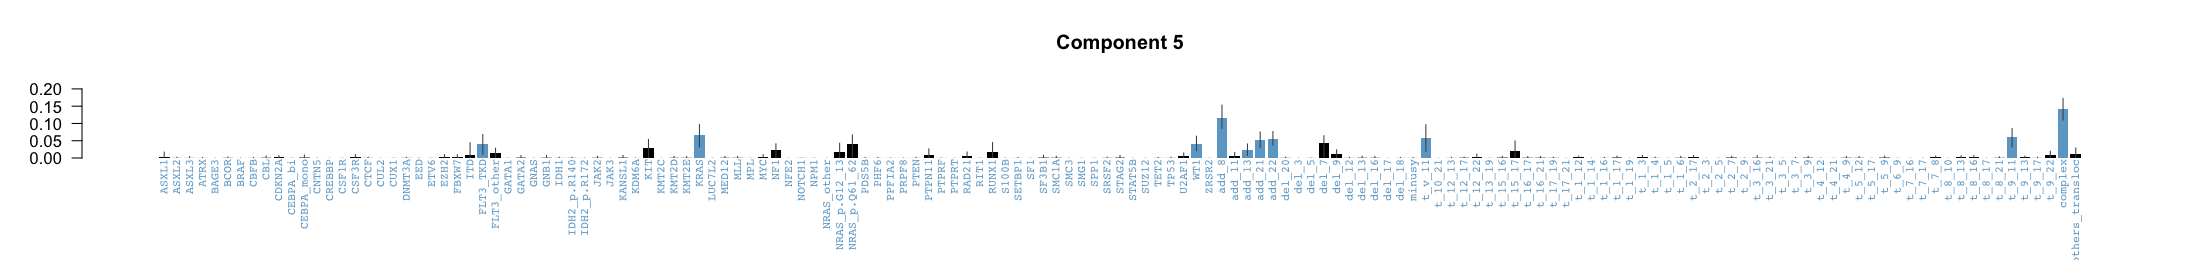

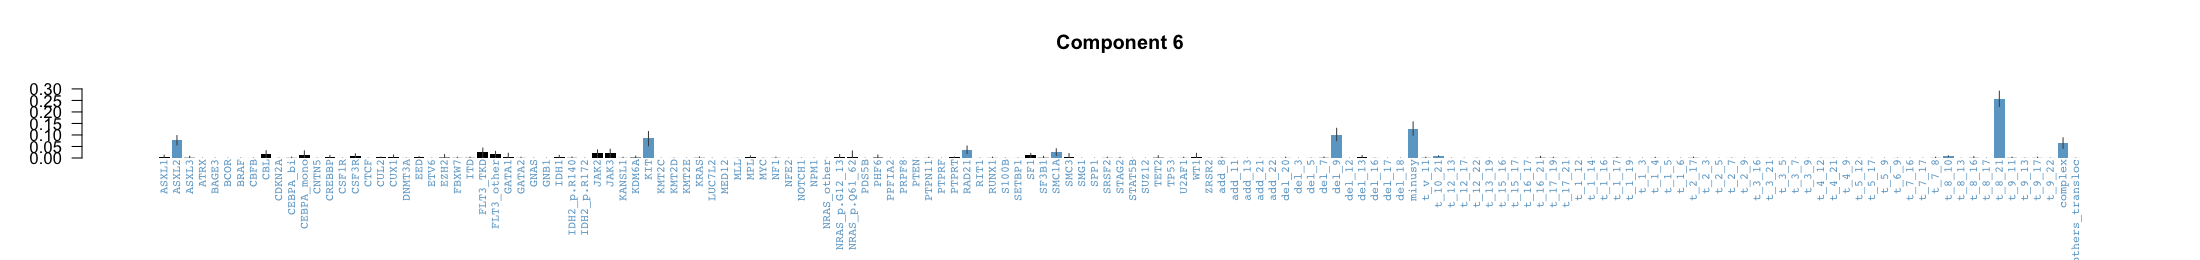

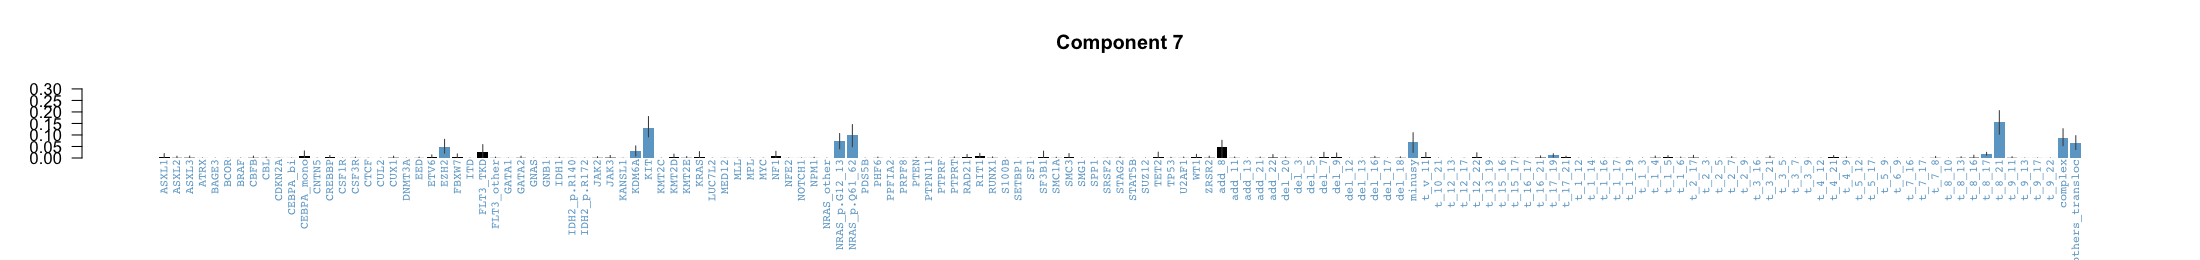

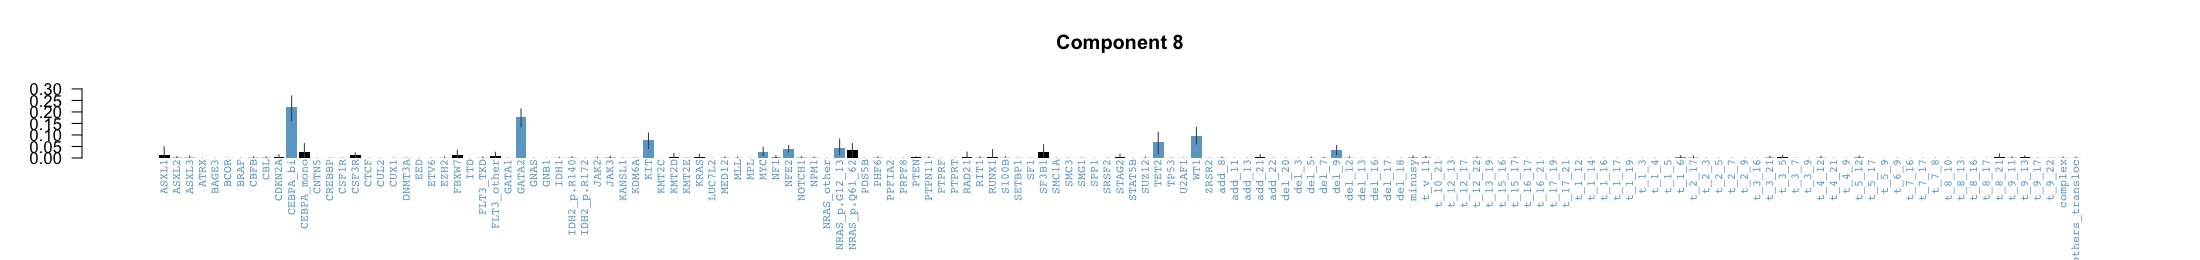

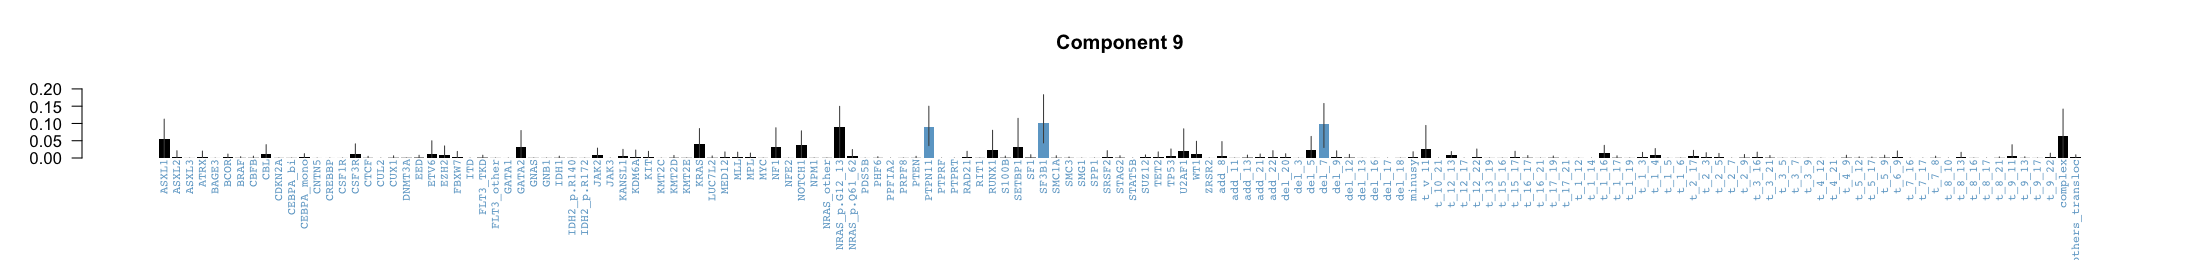

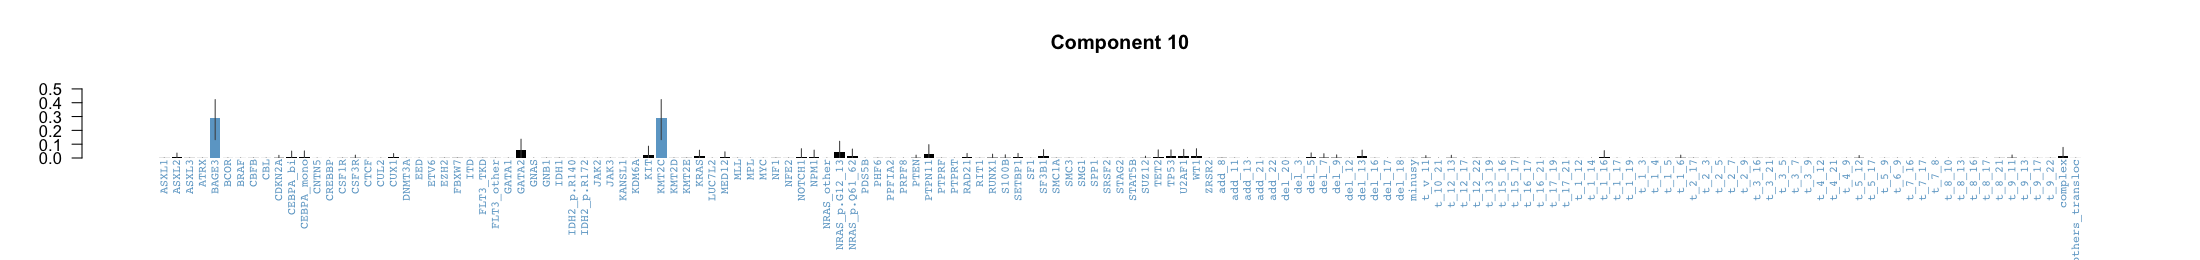

In [10]:
#plot_category_distribution_by_component(multi_output_cluster_10, colnames(df_final))
plot_components_size(multi_output_cluster_10,8,4.5)
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                                         )

Number of components: 10
Number of NA rows   : 56


values      count freq             
2  1            851  39.5813953488372 
3  2            453  21.0697674418605 
4  3            224  10.4186046511628 
5  4            180  8.37209302325581 
6  5            136  6.32558139534884 
7  6             80  3.72093023255814 
8  7             62  2.88372093023256 
12 NaN           56  2.6046511627907  
9  8             48  2.23255813953488 
10 9             27  1.25581395348837 
1  0             25  1.16279069767442 
11 10             8  0.372093023255814
13 -- total -- 2150  100%

notch went outside hinges. Try setting notch=FALSE.


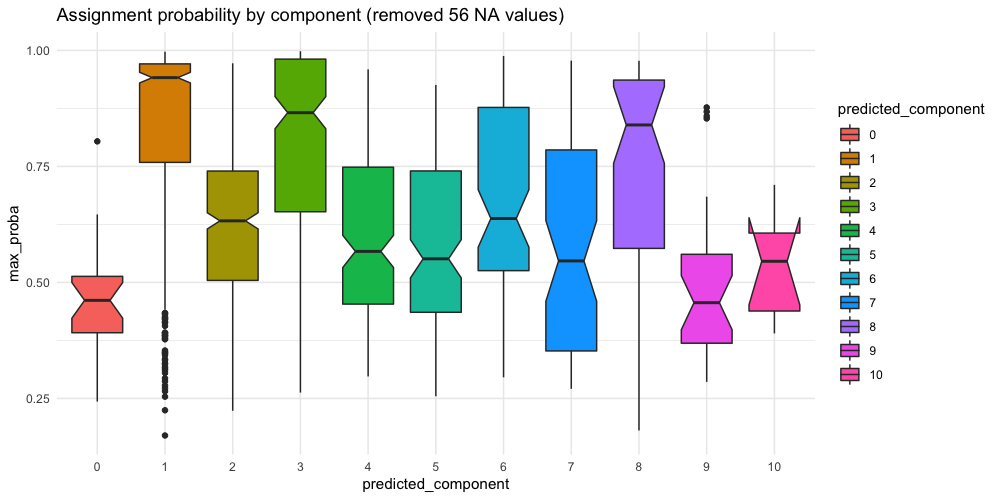

In [12]:
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
get_table(dd_predicted_10_components[,'predicted_component'])
plot_assignement_probability_by_component(dd_predicted_10_components)

# Let's remove component 0,2 and 4 and rename component : component 1 to 8.

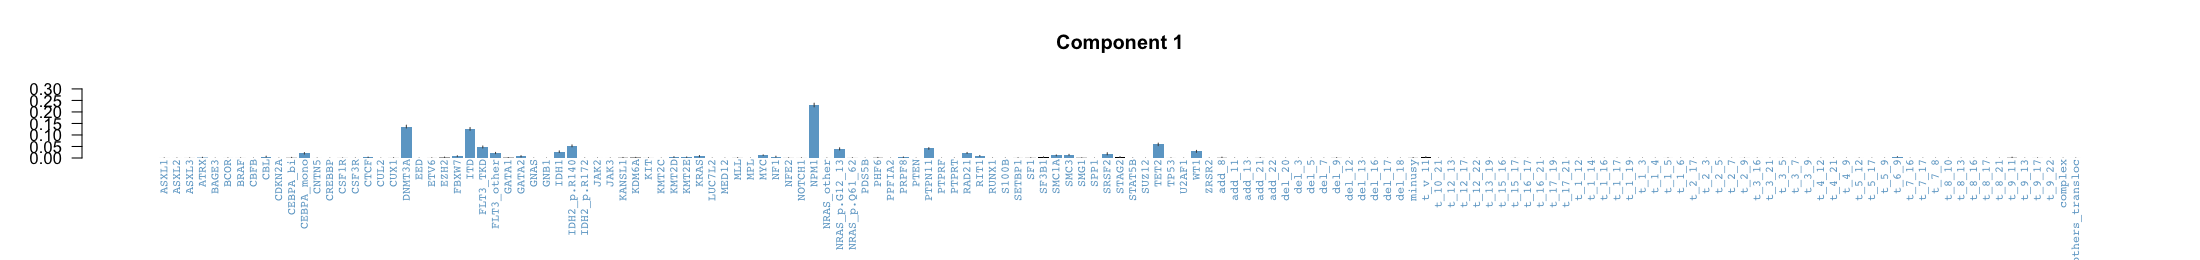

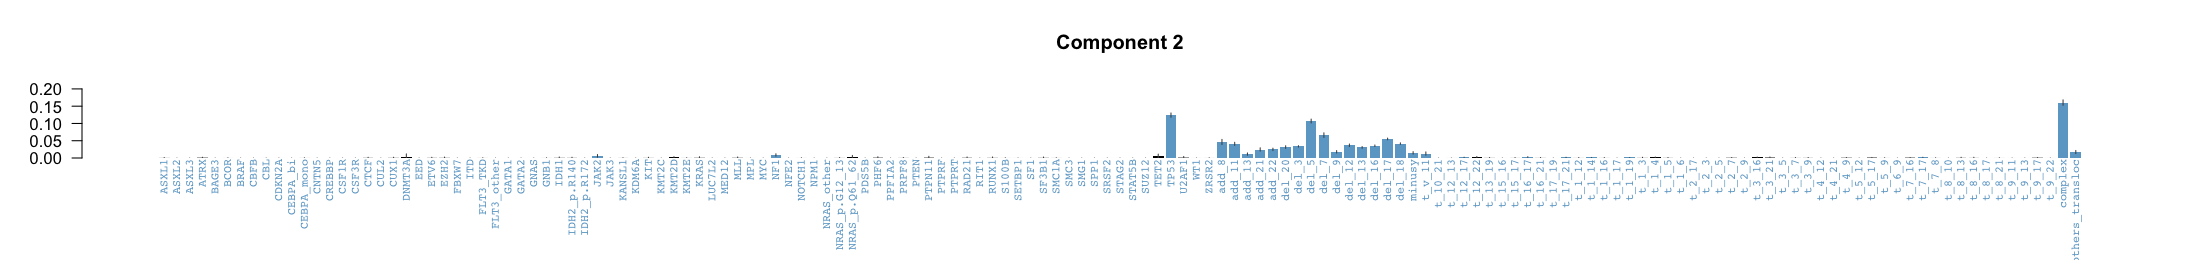

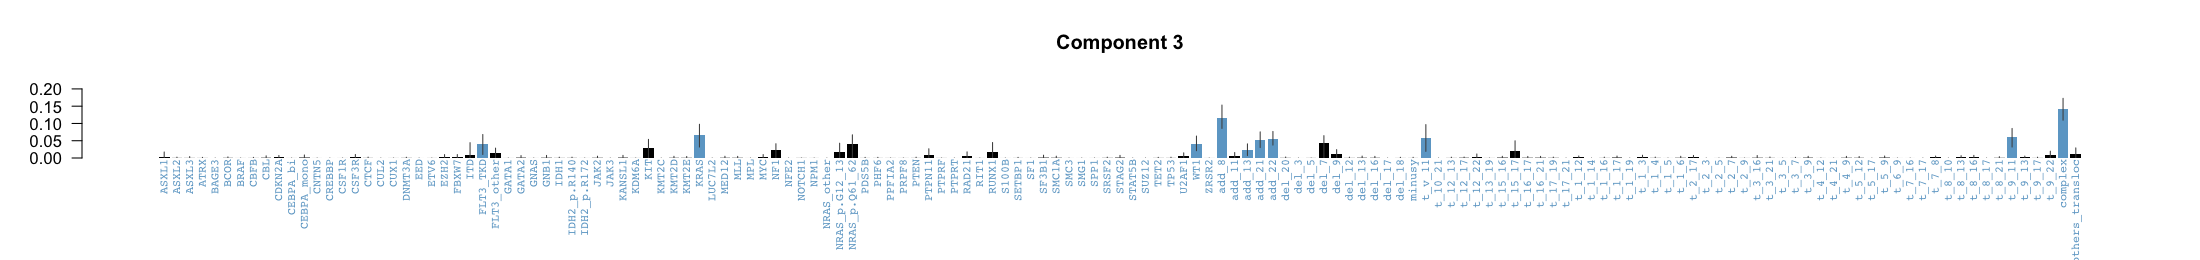

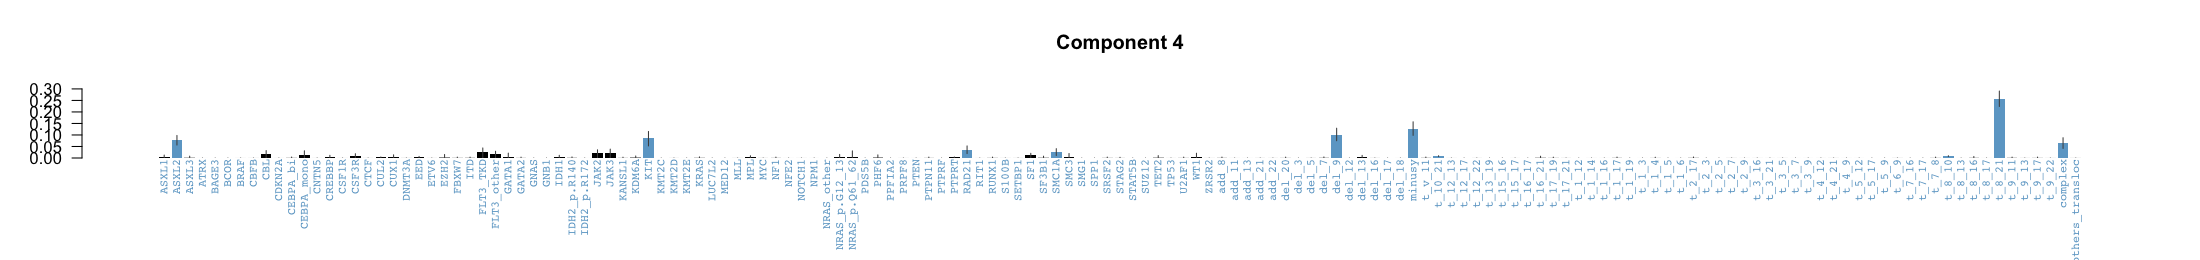

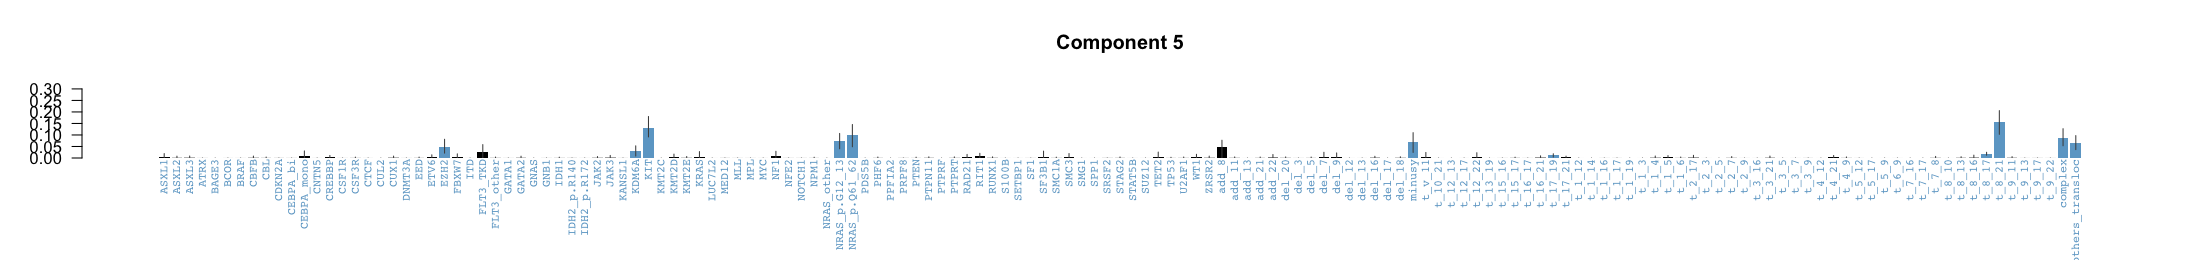

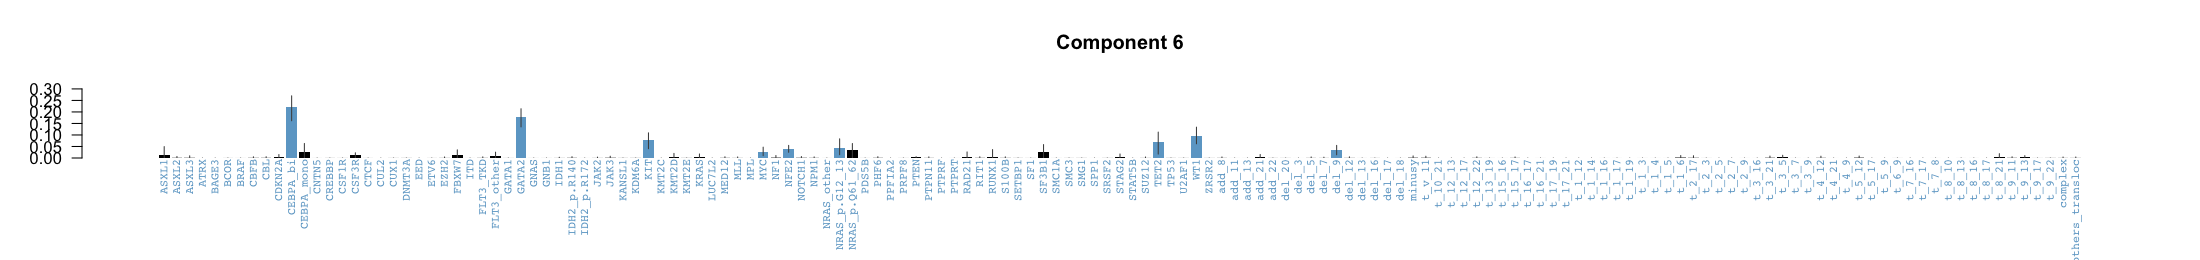

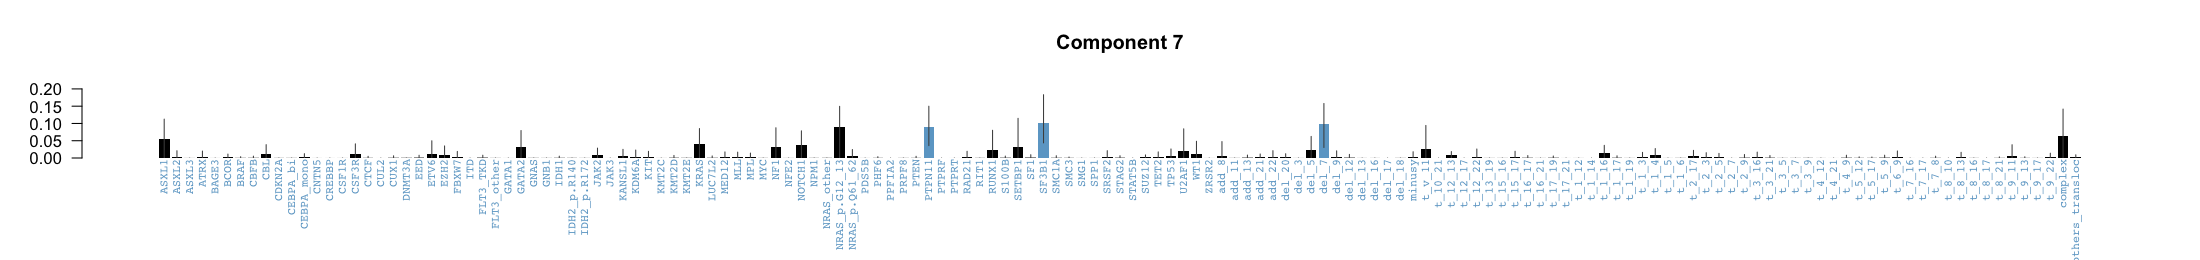

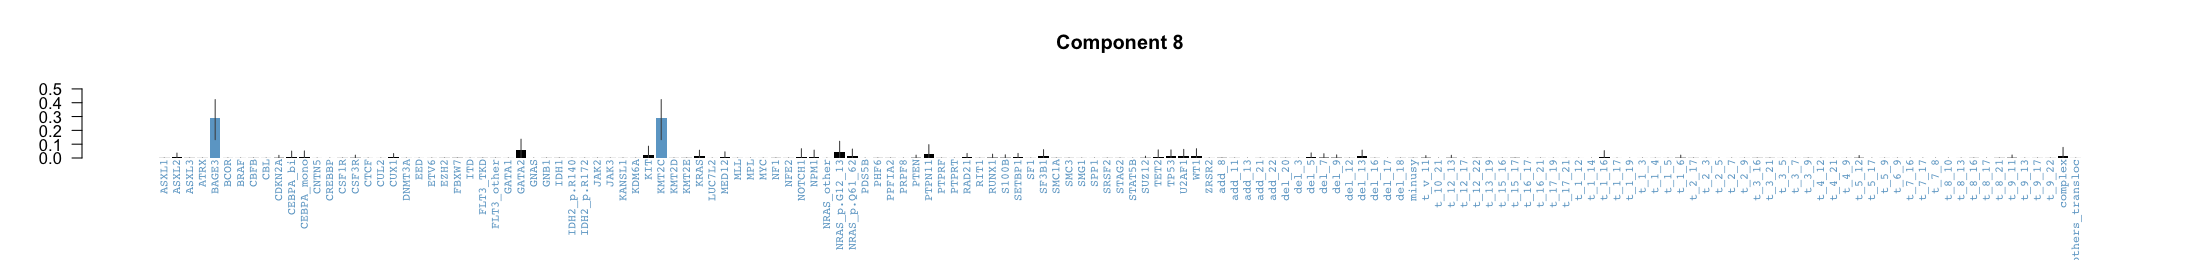

In [13]:
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=c(1,3,5,6,7,8,9,10),
                    plot_title=c("Component 1","Component 2","Component 3","Component 4","Component 5","Component 6","Component 7","Component 8")
                                         )

# II- HDP reapplied ONLY on component 0 , 2 and 4

##### We have finally decided to keep the HDP leading to 10 components. We will isolate component 0, 2 and 4 and reapply a new optimised HDP clustering on them.

Let's work on people in cluster 0,2 and 4

In [14]:
df_clustered_10_c <- cbind(df_final, dd_predicted_10_components)
df_to_recluster <- df_clustered_10_c[df_clustered_10_c$predicted_component==0 | df_clustered_10_c$predicted_component==2 | df_clustered_10_c$predicted_component==4,]
df_to_recluster <- df_to_recluster[,1:151]  # to keep only columns representing features ( we get rid of the proba components)
df_to_recluster <- na.omit(df_to_recluster)

In [15]:
paste("Number of people in component 0,2 and 4 : ",dim(df_to_recluster)[1],"")
for (i in c(0,2,4))
    print(paste("Number of people in component ",sep=paste(i,":"," "),dim(df_clustered_10_c[df_clustered_10_c$predicted_component==i,])[1] ))

[1] "Number of people in component 0,2 and 4 :  658 "

[1] "Number of people in component 0 :  25"
[1] "Number of people in component 2 :  453"
[1] "Number of people in component 4 :  180"


In [16]:
num_cols = ncol(df_to_recluster[colSums(df_to_recluster) > 0])  ## keep only column that have at least a mutation
num_cols
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1)+1)/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

binomial <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],bin))
gaussian <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],normal))
pois <- as.numeric(unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],poisson)))
unif <- unlist(sapply(df_to_recluster[colSums(df_to_recluster) > 0],equally))

[1] 115

In [55]:
data <- df_to_recluster[colSums(df_to_recluster) > 0]
posterior_samples <- 150
initial_clusters <- 5
burn <- 5000
chains <- 3
base_dist <- gaussian
aa <- 1
ab <-1
multi_output <- launch(df_to_recluster[colSums(df_to_recluster) > 0],base_dist,initial_clusters,burn,posterior_samples,chains,aa,ab)
multi_output_recluster_7 <- extract_components(multi_output)


Initialise HDP on a 658 x 115 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...


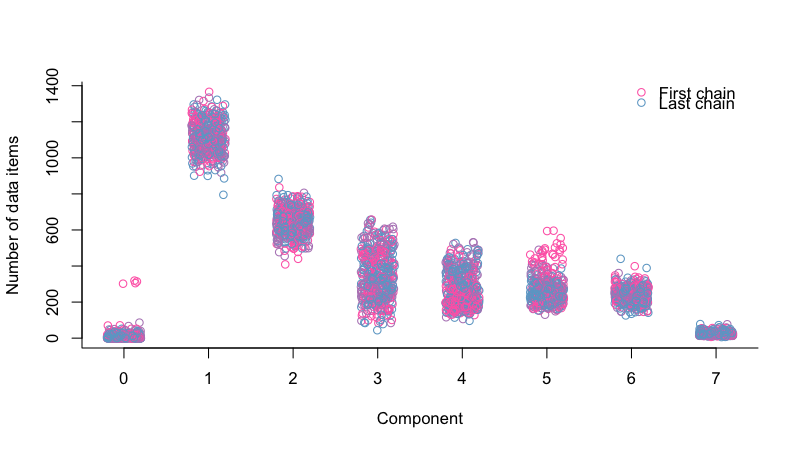

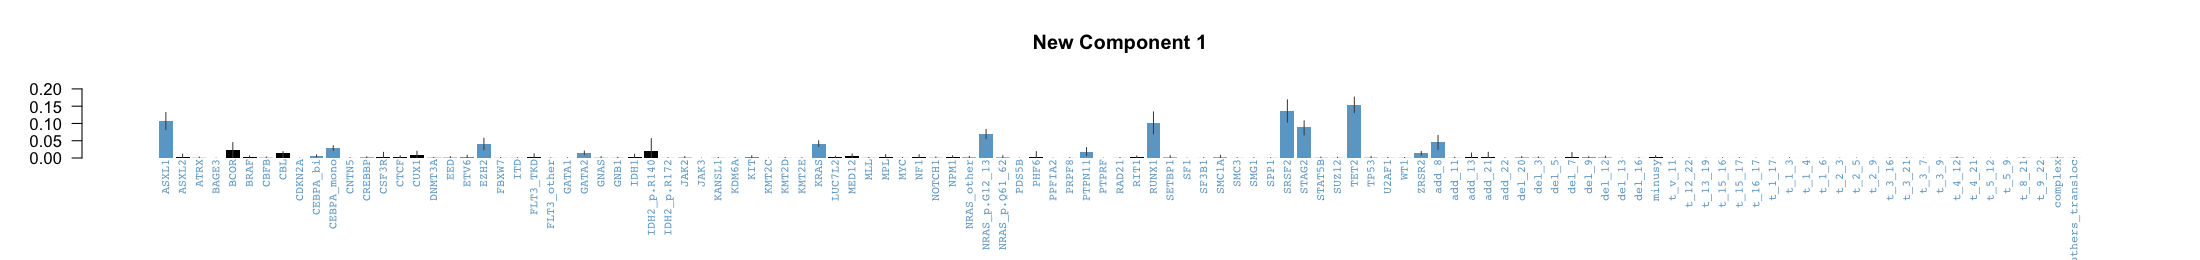

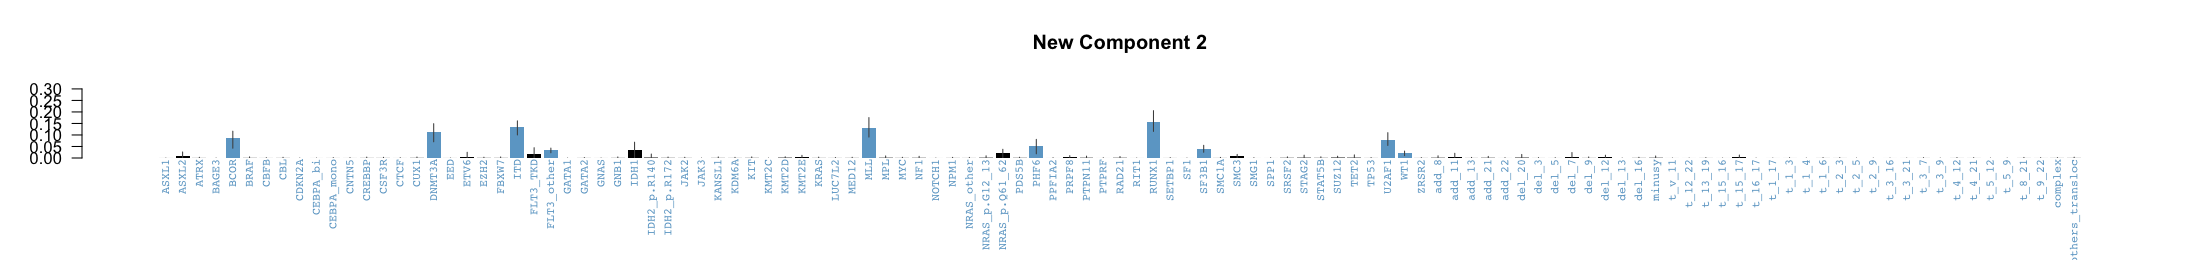

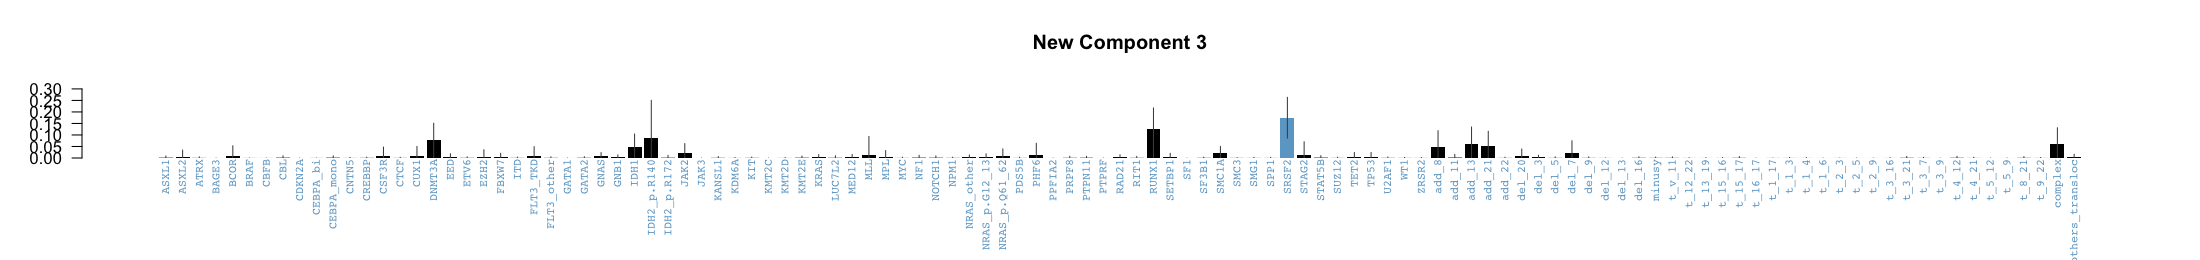

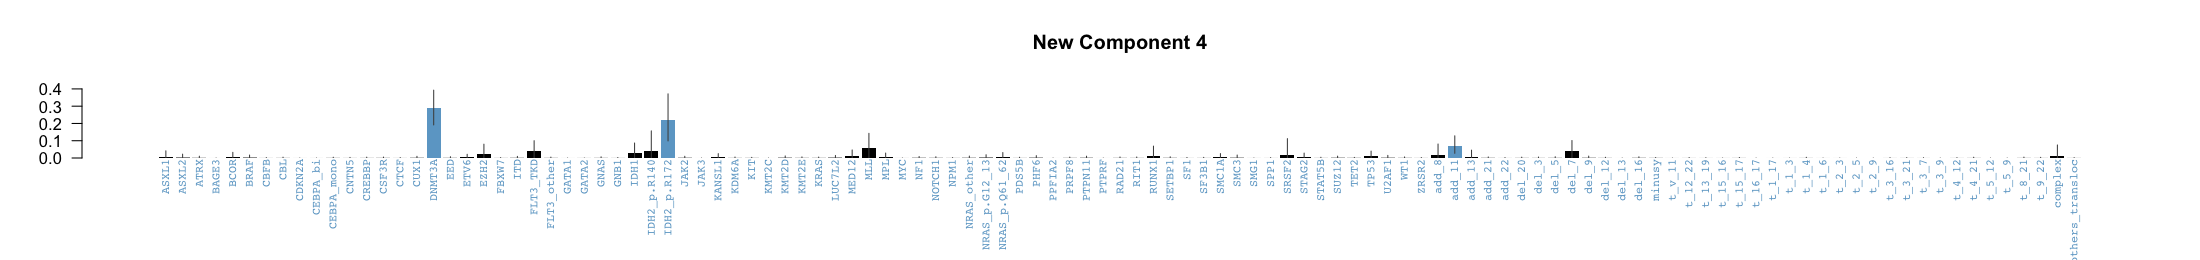

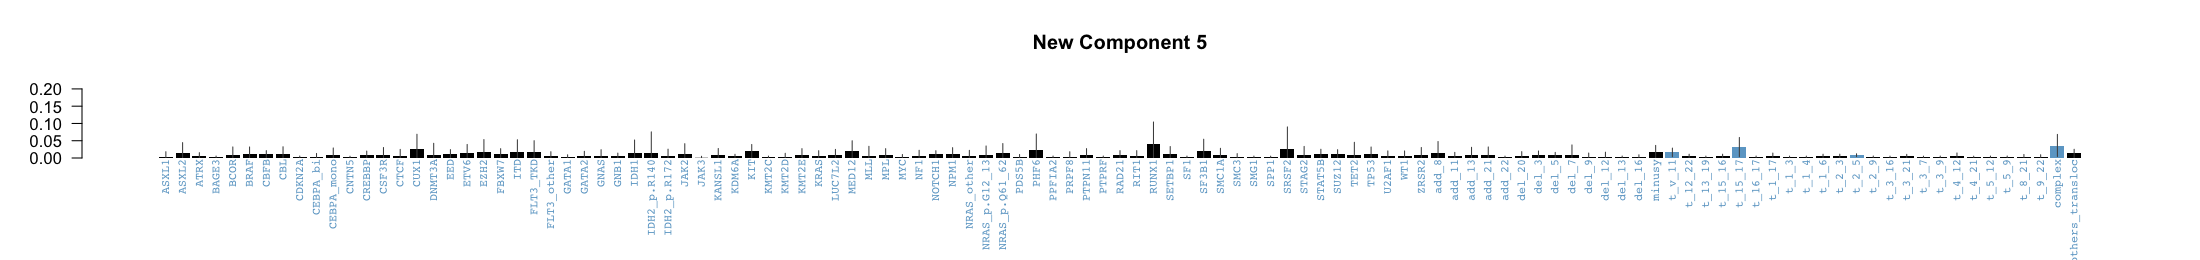

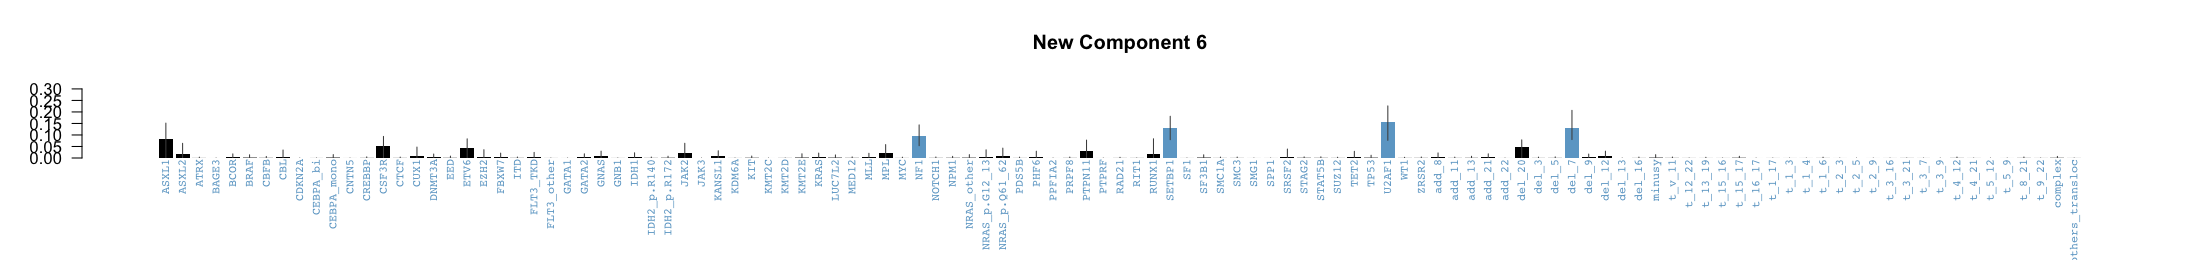

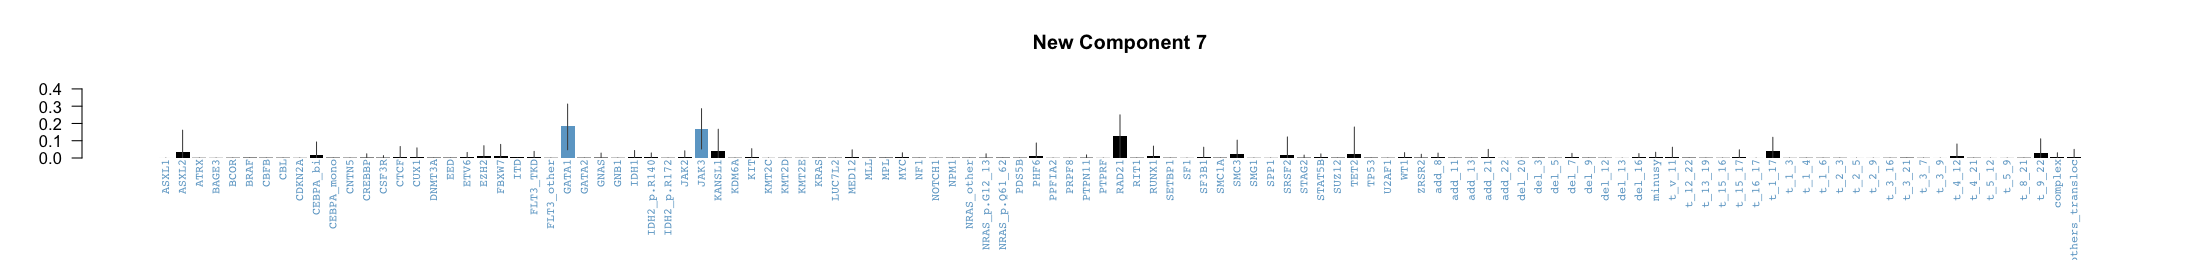

In [18]:
plot_components_size(multi_output_recluster_7,8,4.5)
set_notebook_plot_size(22,2.6)
plot_comp_distn(multi_output_recluster_7,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=1:7,
                    plot_title=c("New Component 1","New Component 2","New Component 3","New Component 4","New Component 5","New Component 6","New Component 7"))



Number of components: 7
Number of NA rows   : 0


values      count freq             
1  1           304   46.2006079027356 
2  2           170   25.8358662613982 
4  4            58   8.81458966565349 
3  3            52   7.90273556231003 
6  6            39   5.92705167173252 
5  5            30   4.55927051671733 
7  7             5   0.759878419452888
11 -- total -- 658   100%

notch went outside hinges. Try setting notch=FALSE.


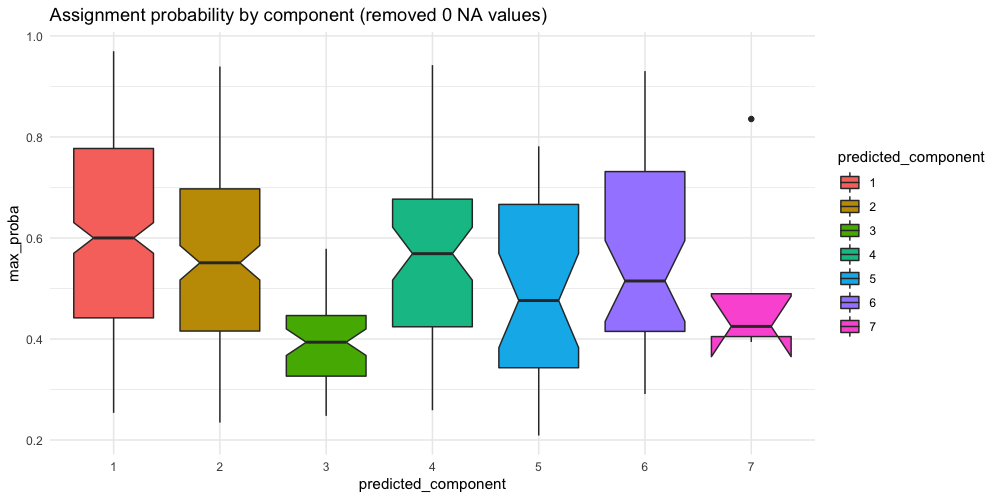

In [19]:
dd_predicted_recluster_7 <- get_prediction_result_dataframe(multi_output_recluster_7, df_to_recluster[colSums(df_to_recluster) > 0])
get_table(dd_predicted_recluster_7[,'predicted_component'])
plot_assignement_probability_by_component(dd_predicted_recluster_7)

#Let's look at the repartition of initial component 0,2 and 4 in their new HDP Clustering : new component 1 to 7

In [20]:
df_10_component <- cbind(df_final, dd_predicted_10_components)
df_7_component <- df_10_component[df_10_component$predicted_component == 0 | df_10_component$predicted_component == 2 | df_10_component$predicted_component == 4 ,]
df_7_component$predicted_old_component <- df_7_component$predicted_component
df_7_component <- df_7_component['predicted_old_component']
df_7_component <- na.omit(df_7_component)
tmp <- cbind(df_7_component, dd_predicted_recluster_7['predicted_component'])

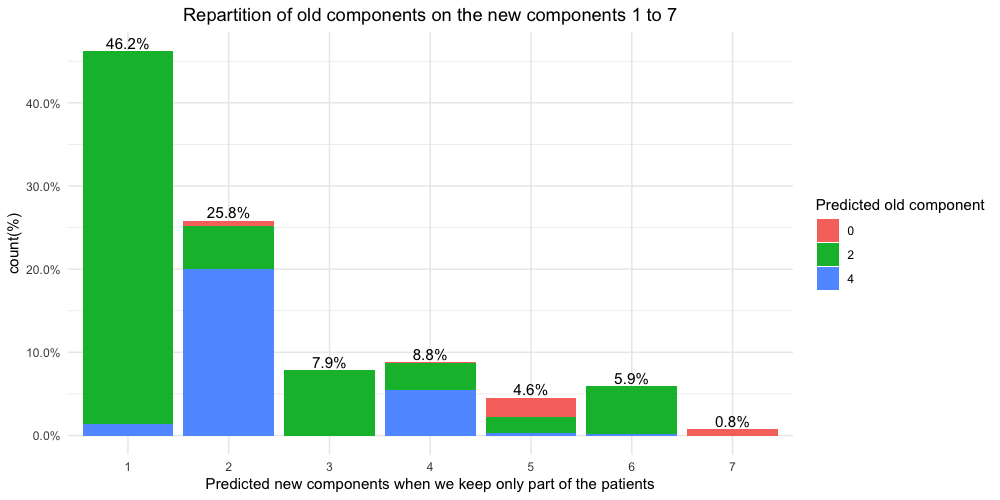

In [21]:
ggplot(tmp, aes(predicted_component)) +
geom_bar(aes(y = (..count..)/sum(..count..),fill=factor(predicted_old_component)))+
geom_text(aes(y = ((..count..)/sum(..count..)), label = scales::percent((..count..)/sum(..count..))), stat = "count", vjust = -0.25) +
scale_y_continuous(labels = percent) +
labs(x = "Predicted new components when we keep only part of the patients",title="Repartition of old components on the new components 1 to 7",fill="Predicted old component",y="count(%)")+
theme(plot.title = element_text(hjust = 0.5))

## Summary : 
#### We initially started with component 0 to 10 : C0 to C10 .
#### We removed component 0,2 and 4. It means that we now have C1 to C8 with C1 is initial component 1 , C2 is initial component 3, C3 is initial component 5 , C4 is initial component 6 , C5 initial
#### component 7, C6 initial component 8, C7 initial component 9 , C8 initial component 10.
#### On component 0,2 and 4 : we apply new HDP clustering (above) in order to create a repartition of those components into 7 new component (NC1 to NC7).
#### Therefore, we now have : C1 ... C8 and NC1 ... NC7

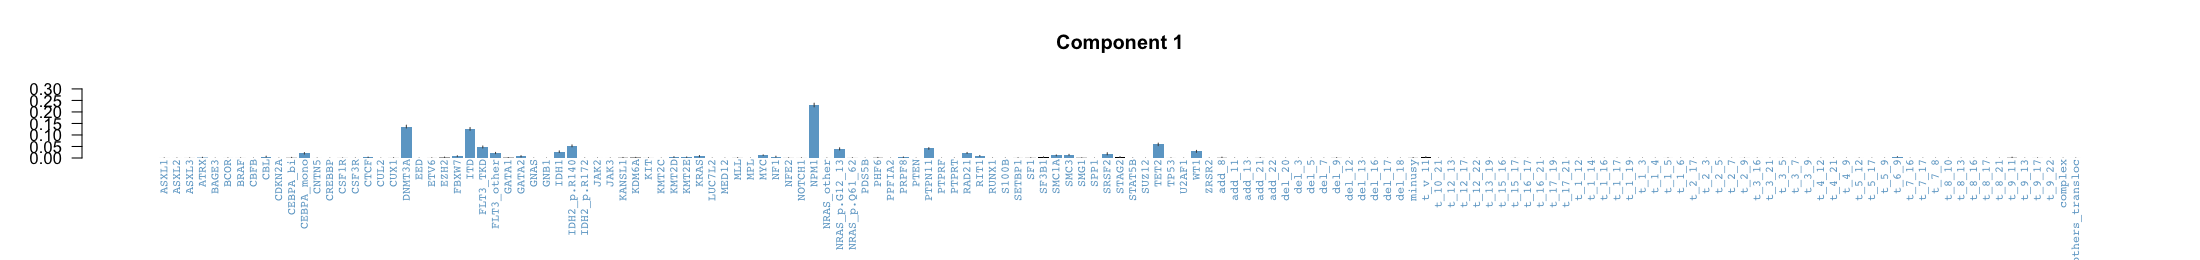

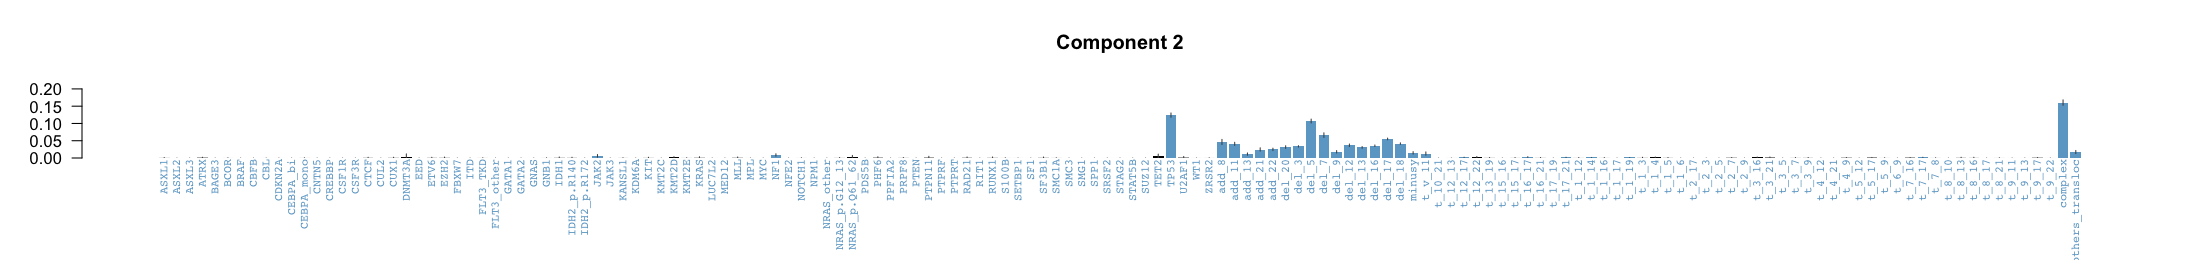

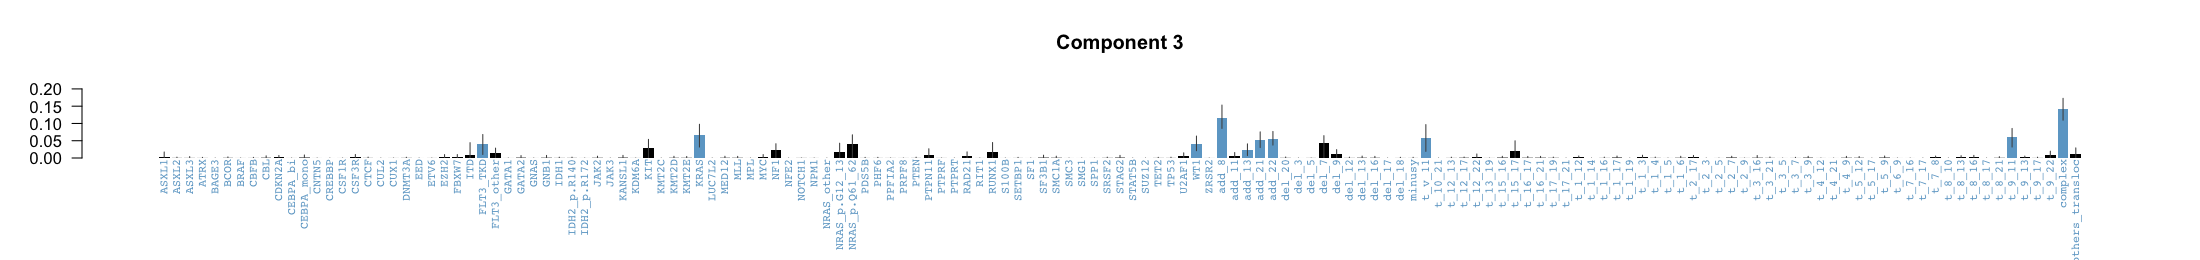

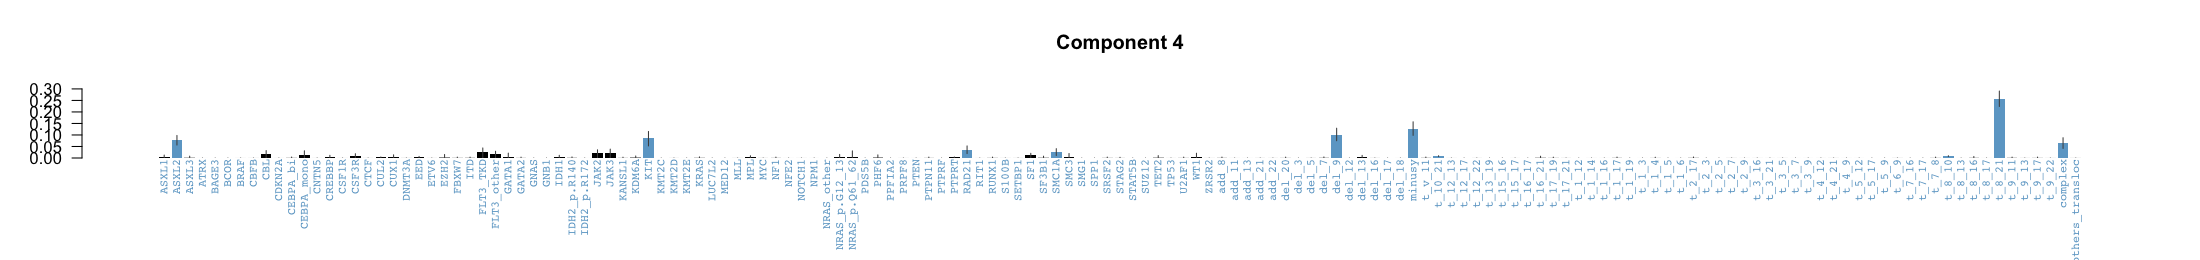

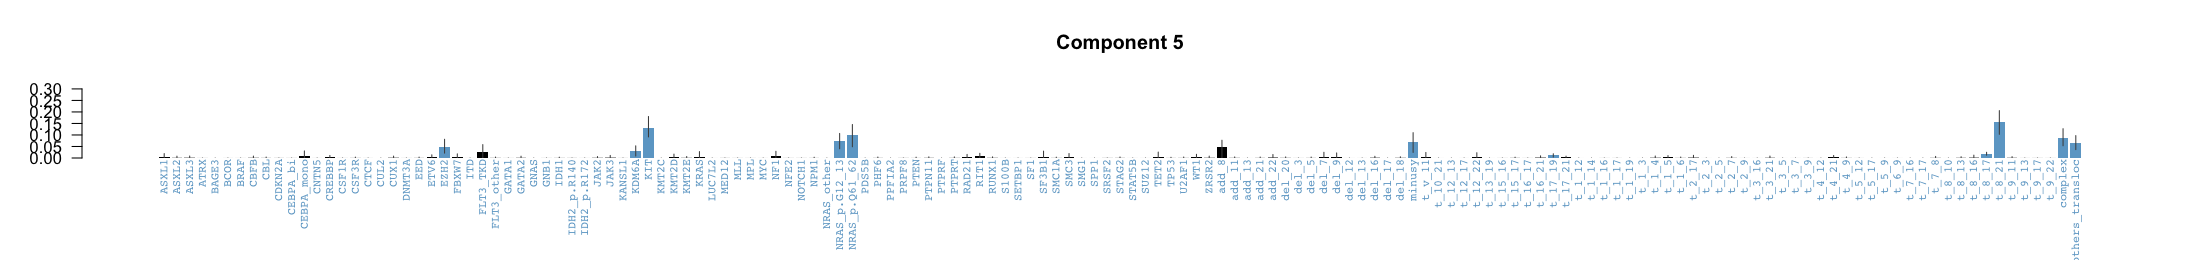

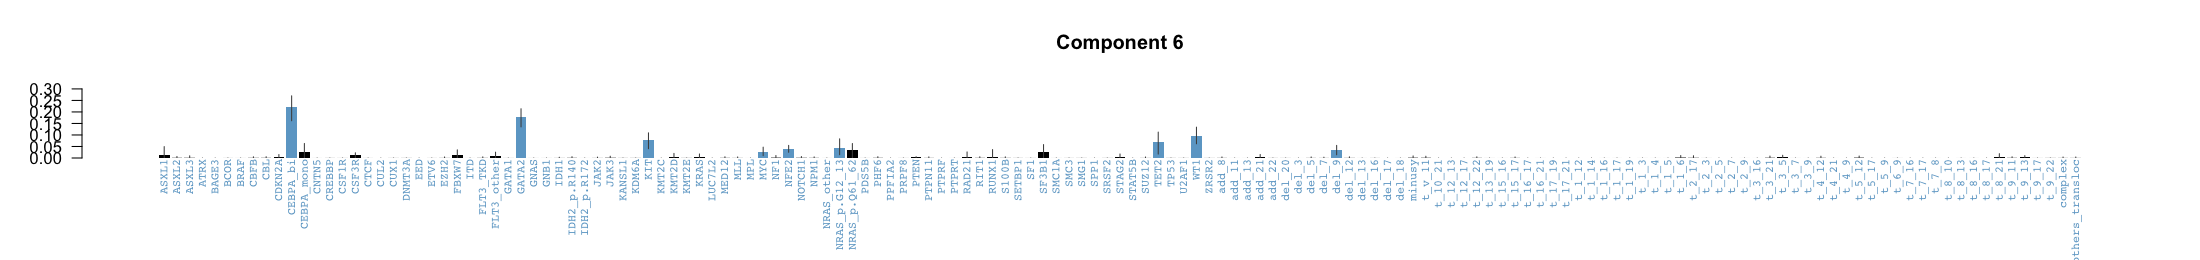

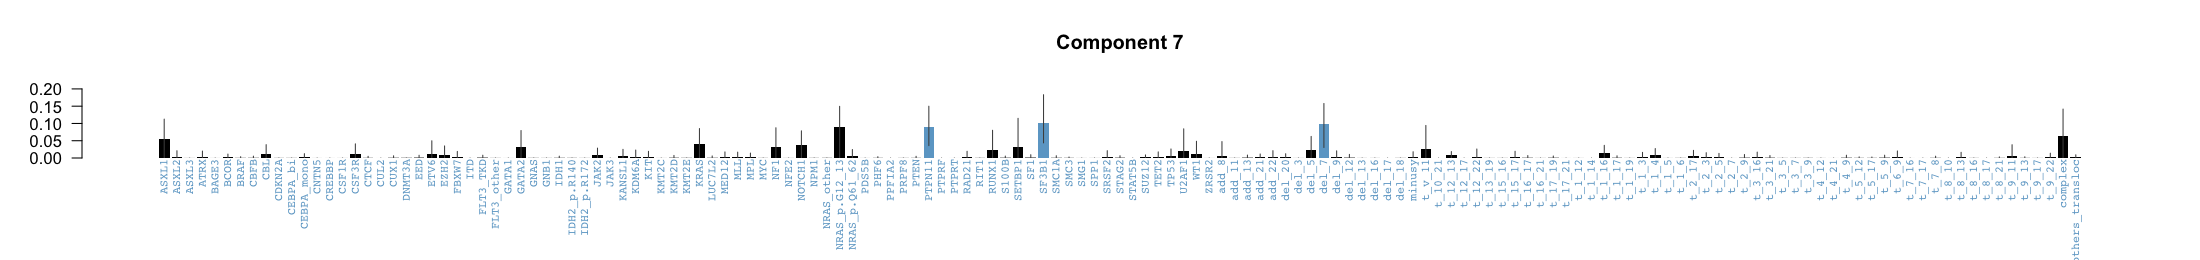

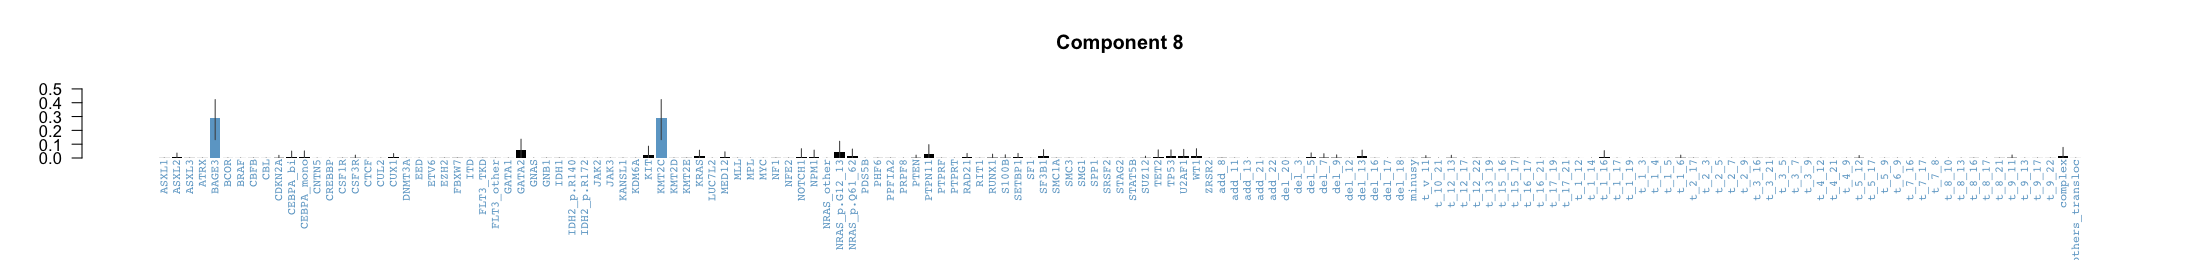

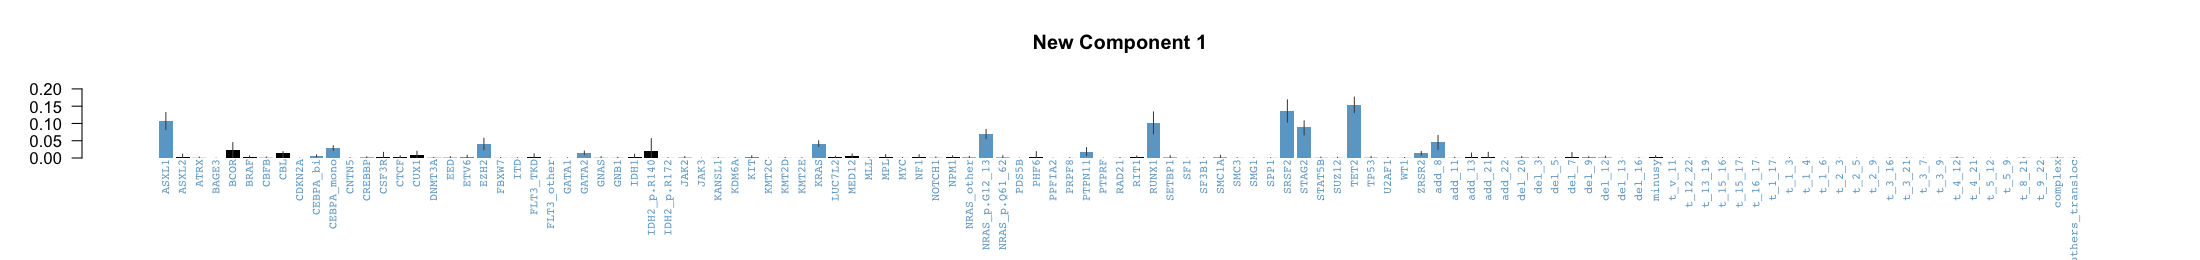

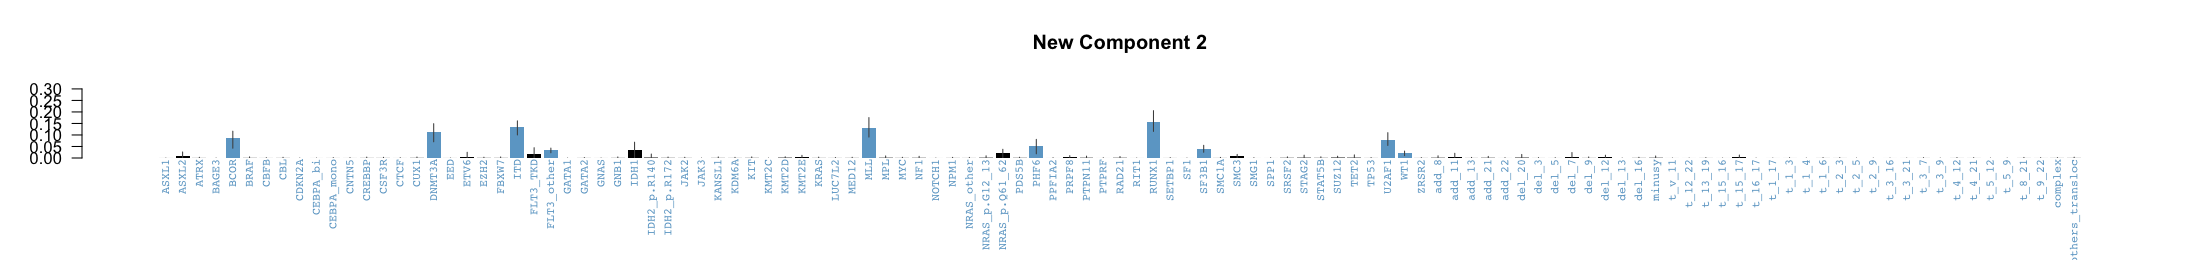

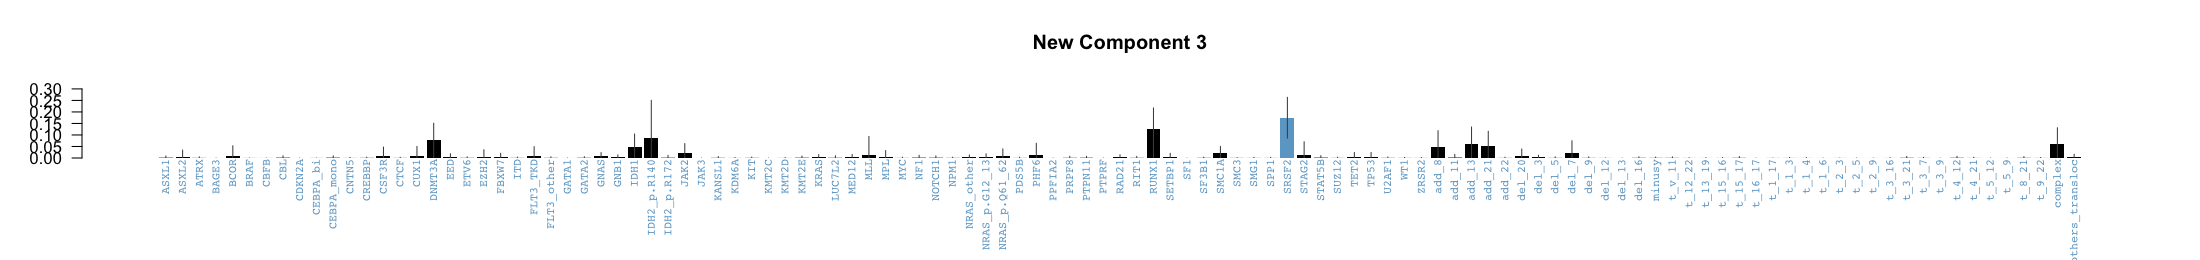

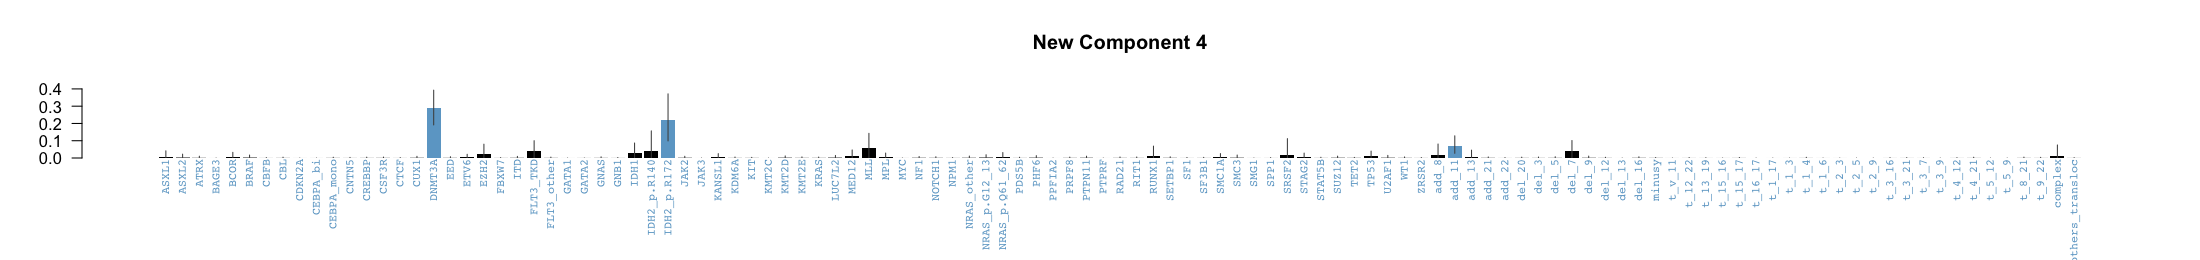

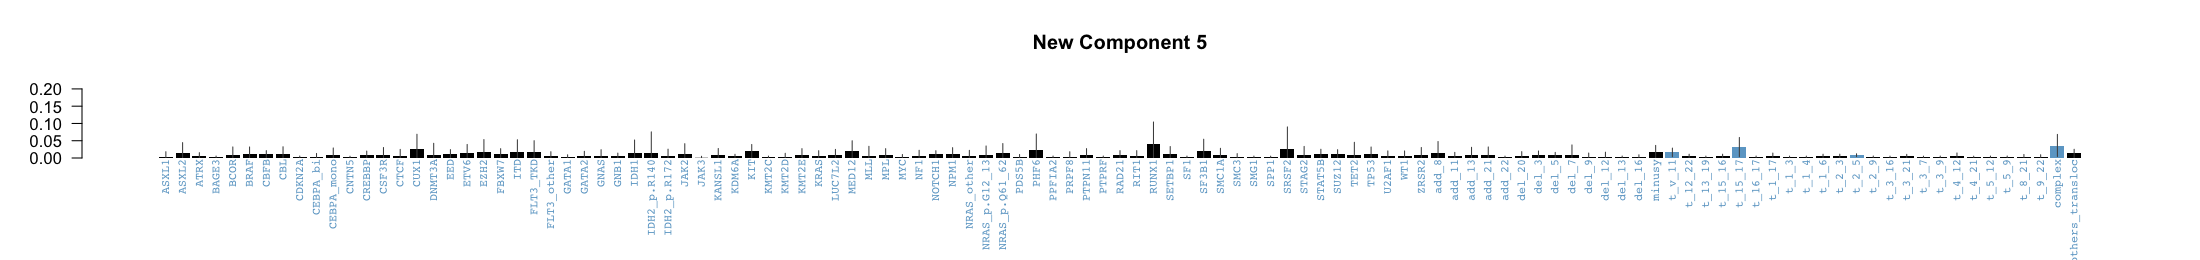

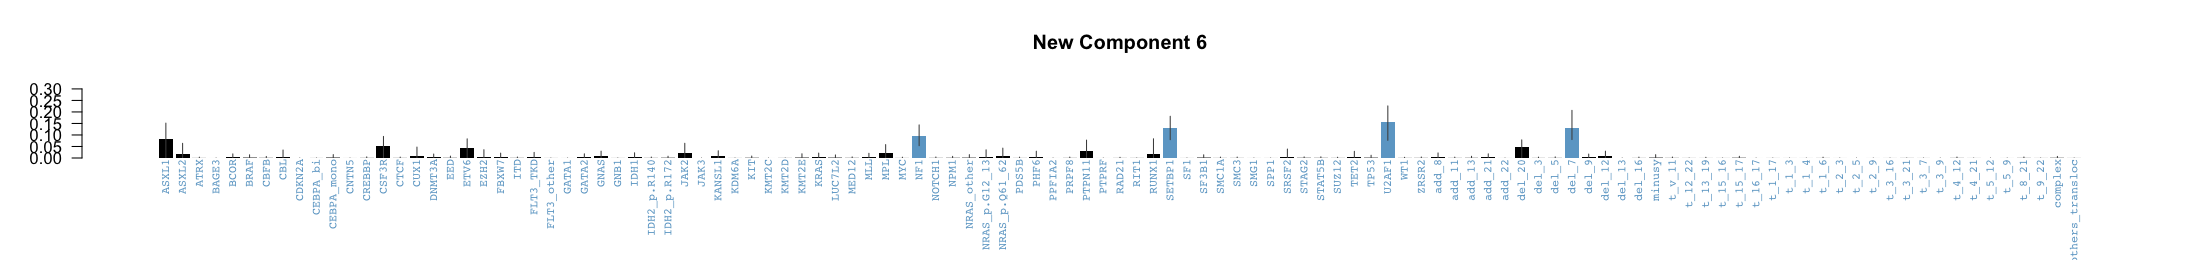

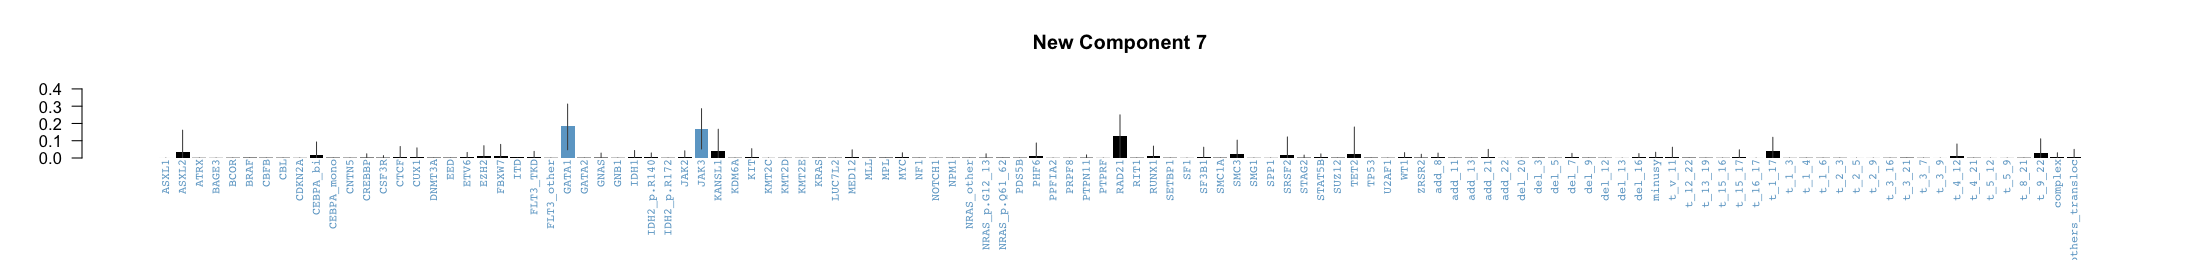

In [22]:
set_notebook_plot_size(22, 2.6)
    plot_comp_distn(multi_output_cluster_10,
                    cat_names  = colnames(df_final),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=c(1,3,5,6,7,8,9,10),
                    plot_title=c("Component 1","Component 2","Component 3","Component 4","Component 5","Component 6","Component 7","Component 8")
                                         )
    plot_comp_distn(multi_output_recluster_7,
                    cat_names  = colnames(df_to_recluster[colSums(df_to_recluster) > 0]),
                    col        = "skyblue3",
                    col_nonsig = "black",
                    comp=1:7,
                    plot_title=c("New Component 1","New Component 2","New Component 3","New Component 4","New Component 5","New Component 6","New Component 7"))

# Refine Clustering

### Prepare dataframe with new definition of complex

In [236]:
df_all_components <- read.table("../../../data/updated_dataset/all_components.tsv",sep = '\t' , header = T)
df_all_components$complex <-NULL
tmp <- read.table("../../prognosis/InitialPrognosis/df_prognosis.tsv")
df_all_components <-merge(df_all_components,tmp["new_complex"],by=0)
rownames(df_all_components) <- df_all_components$Row.names
df_all_components <- df_all_components[,-1]
colnames(df_all_components)[colnames(df_all_components)=="new_complex"] <- "complex"

df_all_components$predicted_component <- apply(df_all_components, 1, function(x) { if (all(is.na(x['predicted_component'])))
                                                                                  return(NaN)
                                                                             else return(ifelse(x['predicted_component']==1,"C1",
                                                                                          ifelse(x['predicted_component']==2,"C2",
                                                                                         ifelse(x['predicted_component']==3,"C3",
                                                                                          ifelse(x['predicted_component']==4,"C4",
                                                                                          ifelse(x['predicted_component']==5,"C5",
                                                                                          ifelse(x['predicted_component']==6,"C6",
                                                                                          ifelse(x['predicted_component']==7,"C7",
                                                                                          ifelse(x['predicted_component']==8,"C8",
                                                                                          ifelse(x['predicted_component']==9,"NC1",  
                                                                                          ifelse(x['predicted_component']==10,"NC2",
                                                                                          ifelse(x['predicted_component']==11,"NC3", 
                                                                                          ifelse(x['predicted_component']==12,"NC4", 
                                                                                          ifelse(x['predicted_component']==13,"NC5", 
                                                                                          ifelse(x['predicted_component']==14,"NC6",    
                                                                                          ifelse(x['predicted_component']==15,"NC7","others"))))))))))))))))
                                                                            })


### We first use multi output cluster 10 for this part because this is the first hdp analysis.
### We will have a dataframe with predicted component second predicted component and their probas. 

In [237]:
add_first_second_predicted_component <- function(hdp_output, data) {
    # Return a dataframe giving for each patient the probability by component, as well as the assigned component and its probability (max_proba)
    # → Arguments
    #     - hdp_output: hdpSampleChain or hdpSampleMulti object
    #     - data      : original data

    # keep all DP but first (first level)
    dd_predicted <- data.frame(comp_dp_distn(hdp_output)$mean[-1,])

# change categories colnames
    colnames(dd_predicted) <- paste0('component_', 0:(ncol(dd_predicted)-1))
    components_colnames <- colnames(dd_predicted)

    # pprint various info
    print_and_flush(sprintf('Number of components: %d\n', ncol(dd_predicted) - 1))
    print_and_flush(sprintf('Number of NA rows   : %d\n', nrow(dd_predicted[rowSums(is.na(dd_predicted)) != 0,])))

    # evaluate for each row the predicted component
    dd_predicted['initial_predicted_component'] <- apply(dd_predicted, 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     return(which.max(x)-1)
                                                                })
    dd_predicted[, 'initial_predicted_component'] <- factor(dd_predicted[, 'initial_predicted_component'])


    dd_predicted['second_predicted_component'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                     return(NaN)
                                                                 else
                                                                     tmp <- names(which.max(x[x!=max(x)]))
                                                                     return(as.numeric(substr(tmp,nchar(tmp),nchar(tmp))))
                                                                })
    dd_predicted[, 'second_predicted_component'] <- factor(dd_predicted[, 'second_predicted_component'])
    
    # evaluate for each row the maximum probability associated to the predicted component
    
    dd_predicted['max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x))
                                                                            })

    dd_predicted['second_max_proba'] <- apply(dd_predicted[,components_colnames], 1, function(x) { if (all(is.na(x)))
                                                                                  return(NaN)
                                                                              else
                                                                                 return(max(x[x!=max(x)]))
                                                                            })

    return (dd_predicted)
}

In [238]:
initial_hdp_predicted <- add_first_second_predicted_component(multi_output_cluster_10)
#initial_hdp_predicted <- na.omit(initial_hdp_predicted)
initial_hdp_predicted <- initial_hdp_predicted[,c('initial_predicted_component','second_predicted_component','max_proba','second_max_proba')]
#initial_hdp_predicted <- initial_hdp_predicted[(initial_hdp_predicted$predicted_component!=0 & initial_hdp_predicted$predicted_component!=2 & initial_hdp_predicted$predicted_component!=4),]

Number of components: 10
Number of NA rows   : 56


In [239]:
df_w_initial_predicted <- cbind(df_final,initial_hdp_predicted)
df_w_initial_predicted <- na.omit(df_w_initial_predicted)


##### We add column complex updated and inv3 :

In [240]:
df_w_initial_predicted$complex <- NULL
df_w_initial_predicted <- merge(df_w_initial_predicted,df_all_components[,c('complex','inv_3','predicted_component')],by=0)
rownames(df_w_initial_predicted) <- df_w_initial_predicted$Row.names
df_w_initial_predicted <- df_w_initial_predicted[,-1]

In [244]:
table(df_w_initial_predicted$predicted_component)
table(df_w_initial_predicted$initial_predicted_component)


 C1  C2  C3  C4  C5  C6  C7  C8 NC1 NC2 NC3 NC4 NC5 NC6 NC7 
851 224 136  80  62  48  27   8 304 170  52  58  30  39   5 


  0   1   2   3   4   5   6   7   8   9  10 NaN 
 25 851 453 224 180 136  80  62  48  27   8   0 

# Component 1

In [252]:
write.table(df_w_initial_predicted,"all_components_with_second_complex_inv3.tsv",quote=F,sep='\t')

In [253]:
study_c_1 <- read.table("all_components_with_second_complex_inv3.tsv")

In [254]:
dim(study_c_1)

[1] 2094  157

In [250]:
table(study_c_1[study_c_1$NPM1==0,]$second_predicted_component)


  0   1   2   3   4   5   6   7   8   9 NaN 
  4   0  53   7  62  30   2   3  17   5   0 